In [ ]:
import sys
# Change this path to your working directory where BDTReweight is installed:
sys.path.append('/exp/minerva/app/users/zihaolin/REWEIGHTworkdir/')

from BDTReweight.analysis import transform_momentum_to_reaction_frame, draw_source_target_distributions_and_ratio
from BDTReweight.reweighter import Reweighter
import uproot

### 2p2h pp chanel:

In [ ]:
# Choose training set size
# total entries: 10,000,000
# size = 200000 # training time ~ 8 min
size = 1000000 # training time ~ 50 min

weight_channel = 'weight_pp'

variables = {'muon_E':'leading_muon_E', 'muon_Px':'leading_muon_px', 'muon_Py':'leading_muon_py', 'muon_Pz':'leading_muon_pz', 'muon_P':'leading_muon_P', 
    'neutrino_E':'init_neutrino_E', 'neutrino_Px':'init_neutrino_px', 'neutrino_Py':'init_neutrino_py',
    'neutrino_Pz':'init_neutrino_pz', 'neutrino_P':'init_neutrino_P',
    'nucleon1_out_E':'leading_proton_E', 'nucleon1_out_Px':'leading_proton_px', 'nucleon1_out_Py':'leading_proton_py', 
    'nucleon1_out_Pz':'leading_proton_pz','nucleon1_out_P':'leading_proton_P',
    'nucleon2_out_E':'subleading_proton_E', 'nucleon2_out_Px':'subleading_proton_px', 'nucleon2_out_Py':'subleading_proton_py', 
    'nucleon2_out_Pz':'subleading_proton_pz','nucleon2_out_P':'subleading_proton_P', 
    'Q_E':'qtransfer_E', 'Q_Px':'qtransfer_px', 'Q_Py':'qtransfer_py', 'Q_Pz':'qtransfer_pz', 'Q_P':'qtransfer_P', weight_channel:weight_channel}

data_folder = '/exp/minerva/data/users/zihaolin/MC_outputs/Valencia/PreFsi'

source_train = uproot.open(f'{data_folder}/KinematicVariables_Enu=_Minerva__Inclusive.root')['T'].arrays(library='pd',entry_start=0, entry_stop=size)[variables.keys()]
target_train = uproot.open(f'{data_folder}/KinematicVariables_Enu=_Minerva__Exclusive.root')['T'].arrays(library='pd',entry_start=size, entry_stop=size*2)[variables.keys()]
# source_test = uproot.open(f'{data_folder}/KinematicVariables_Enu=_Minerva__Inclusive.root')['T'].arrays(library='pd',entry_start=size*2, entry_stop=size*3)[variables.keys()]
# target_test = uproot.open(f'{data_folder}/KinematicVariables_Enu=_Minerva__Exclusive.root')['T'].arrays(library='pd',entry_start=size*3, entry_stop=size*4)[variables.keys()]

source_train = source_train.loc[source_train[weight_channel]>=0]
target_train = target_train.loc[target_train[weight_channel]>=0]
# source_test = source_test.loc[source_test[weight_channel]>=0]
# target_test = target_test.loc[target_test[weight_channel]>=0]


source_train = source_train.rename(columns = variables)
target_train = target_train.rename(columns = variables)
# source_test = source_test.rename(columns = variables)
# target_test = target_test.rename(columns = variables)

source_train = transform_momentum_to_reaction_frame(source_train, selector_lepton='leading_muon', particle_names=['leading_proton','subleading_proton','qtransfer'])
target_train = transform_momentum_to_reaction_frame(target_train, selector_lepton='leading_muon', particle_names=['leading_proton','subleading_proton','qtransfer'])
# source_test = transform_momentum_to_reaction_frame(source_test, selector_lepton='leading_muon', particle_names=['leading_proton','subleading_proton','qtransfer'])
# target_test = transform_momentum_to_reaction_frame(target_test, selector_lepton='leading_muon', particle_names=['leading_proton','subleading_proton','qtransfer'])

# for df in [source_train, source_test, target_train, target_test]:
for df in [source_train, target_train]:
    df['q0'] = df['qtransfer_E']
    df['q3'] = df['qtransfer_P']
    df['Q2'] = df['q3']**2 - df['q0']**2

# train reweighter
reweight_variables = [
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz',
    'subleading_proton_px', 'subleading_proton_py', 'subleading_proton_pz',
    'leading_muon_py', 'leading_muon_pz',
    # 'init_neutrino_E'
]

reweighter = Reweighter(n_estimators=200, learning_rate=0.1, max_depth=4, min_samples_leaf=20, gb_args={'subsample': 1.0})
reweighter.fit(source_train[reweight_variables], target_train[reweight_variables],
            original_weight=source_train[weight_channel],
            target_weight=target_train[weight_channel]
)

reweighter.save_to_pickle(f'/exp/minerva/data/users/zihaolin/BDTReweighters/saved_reweighters_pickle/Valencia/reweighter_MINERvA_flux_Valencia_2p2h_inclusive_to_exclusive_{weight_channel}.pkl')


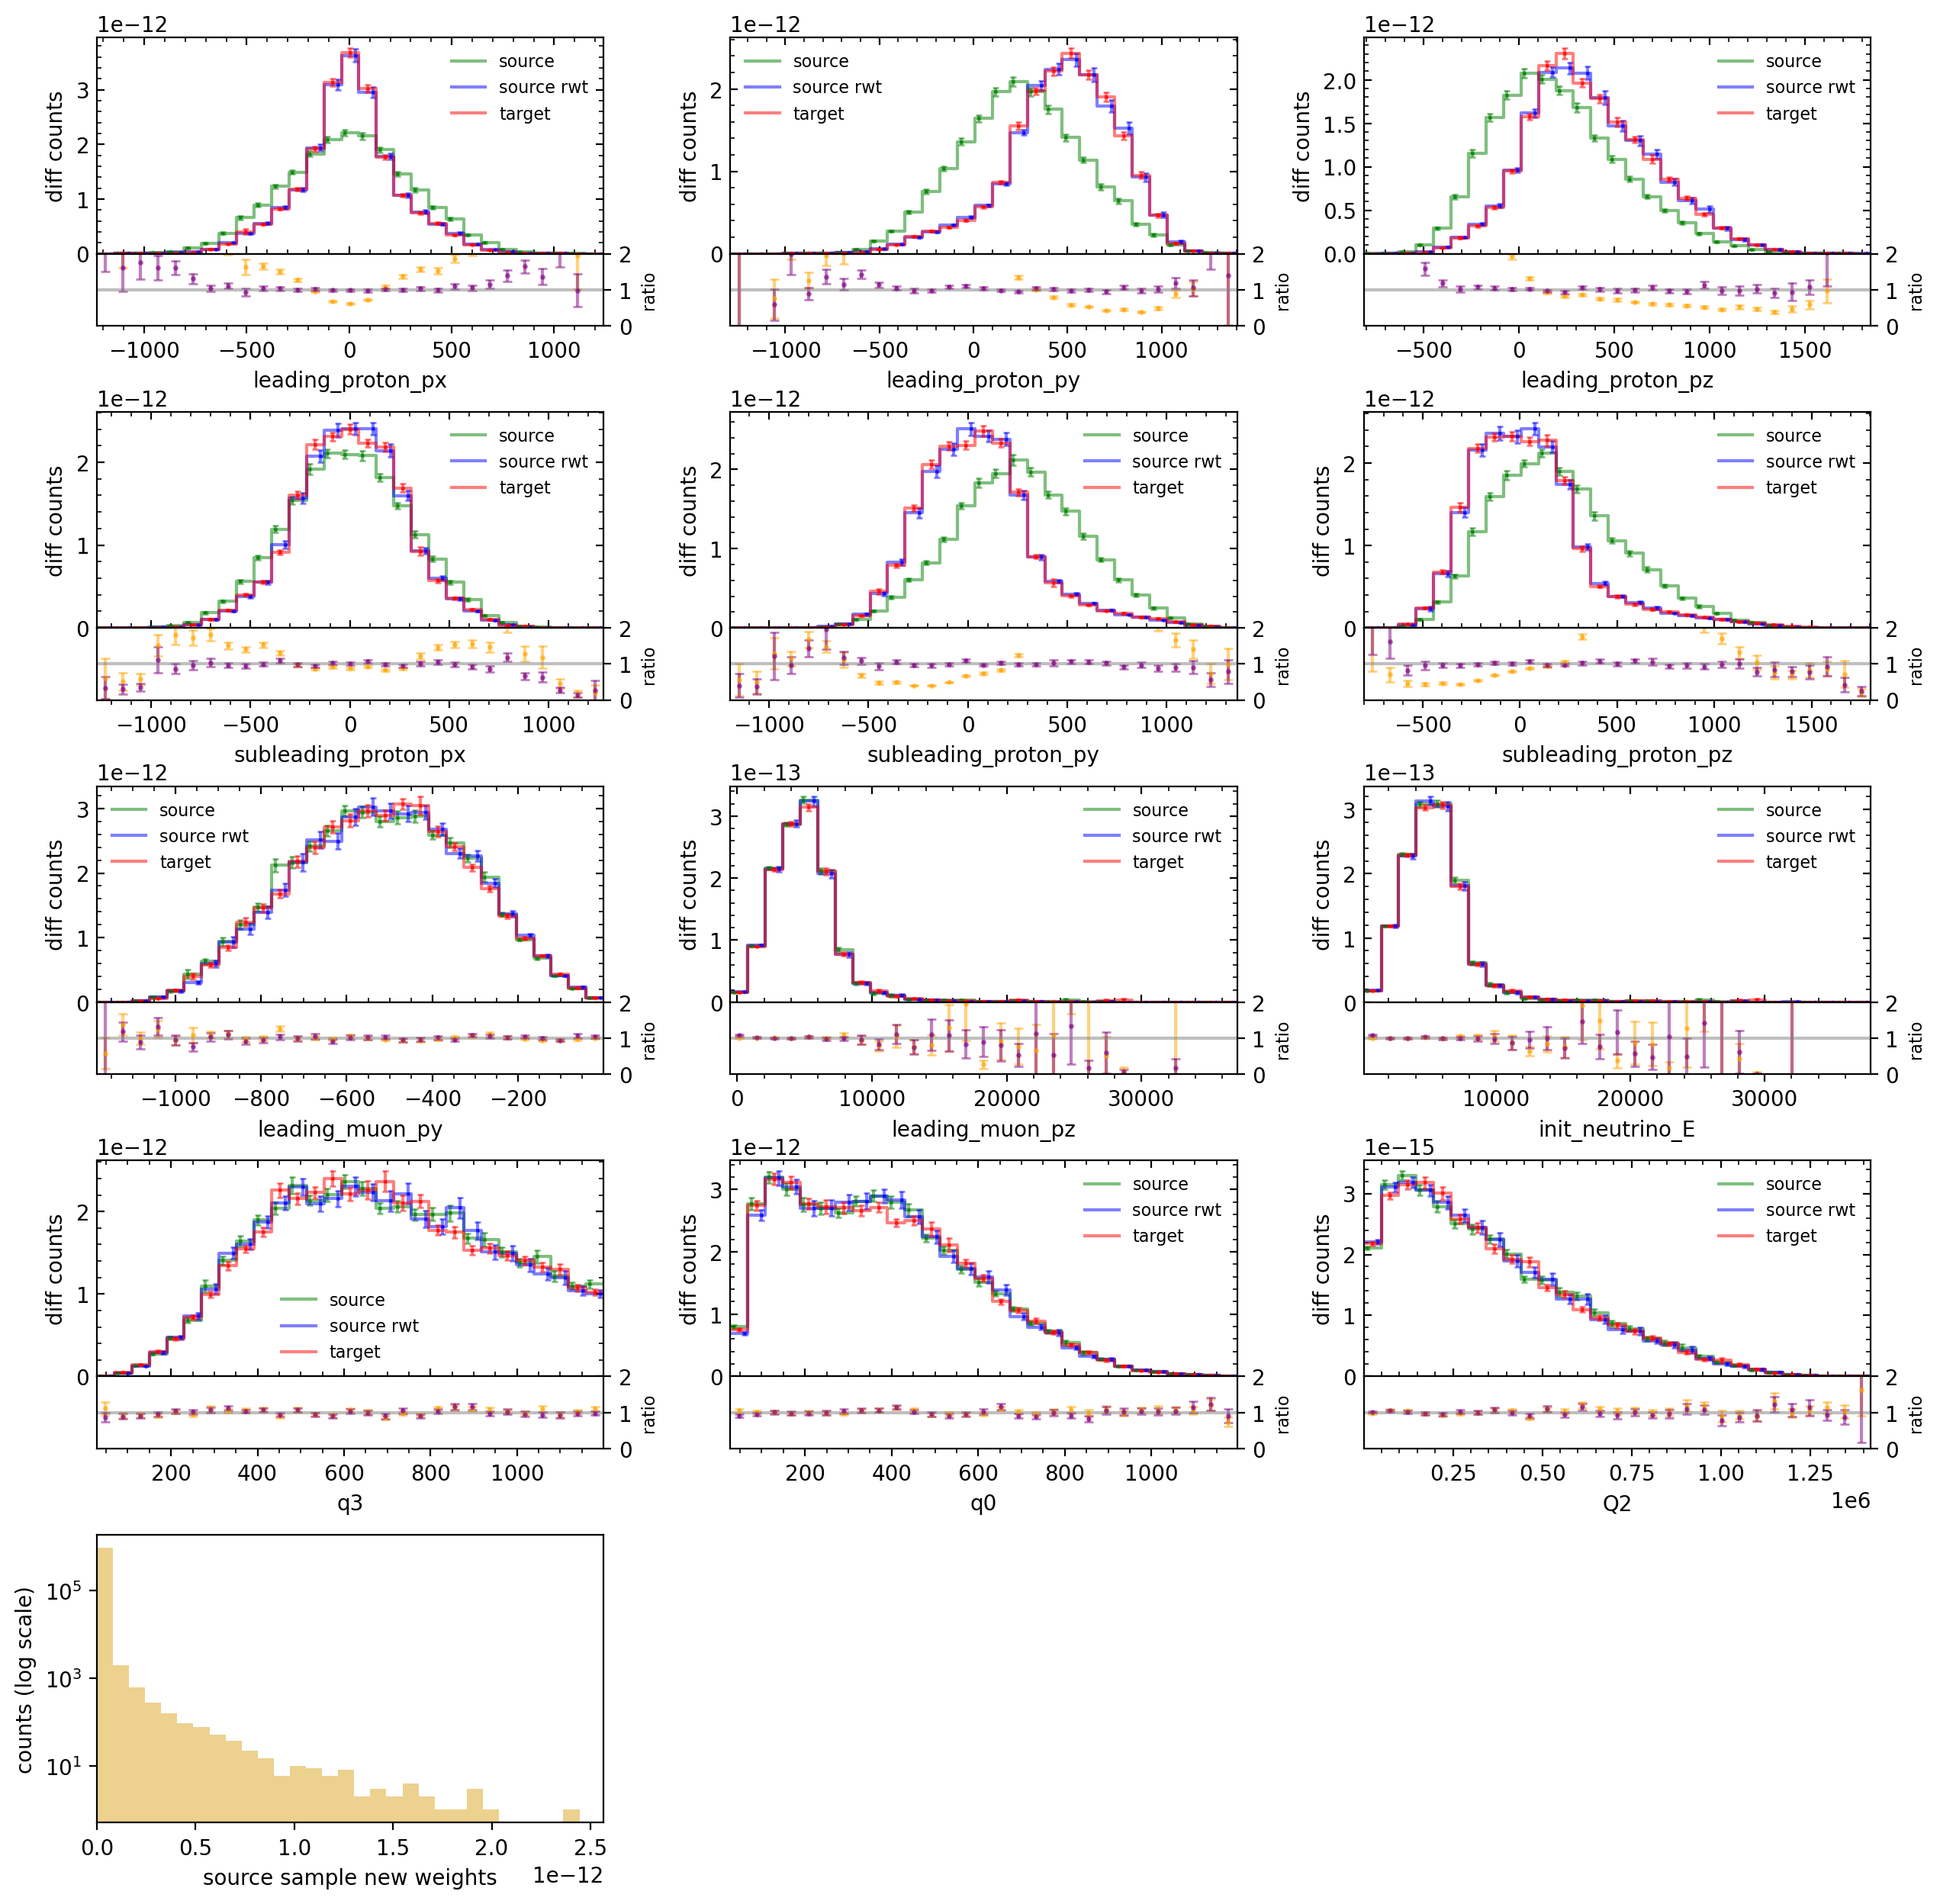

In [33]:
# predict weights
source_train['weight'] = reweighter.predict_matched_total_weights(source_train[reweight_variables], 
            original_weight=source_train[weight_channel],
            target_weight=target_train[weight_channel]
)
# source_test['weight'] = reweighter.predict_matched_total_weights(source_test[reweight_variables], 
#             original_weight=source_test[weight_channel],
#             target_weight=target_test[weight_channel]
# )
drawing_variables=[
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz',
    'subleading_proton_px', 'subleading_proton_py', 'subleading_proton_pz',
    'leading_muon_py', 'leading_muon_pz',
    'init_neutrino_E',
    'q3', 'q0','Q2',
    'weight',
]

mask = source_train['weight']>=0
draw_source_target_distributions_and_ratio(source_train.loc[mask], target_train, variables=drawing_variables,
    source_weights=source_train.loc[mask][weight_channel], 
    new_source_weights=source_train.loc[mask]['weight'], 
    target_weights=target_train[weight_channel]
)


### 2p2h pn chanel:

In [ ]:
# Choose training set size
# total entries: 10,000,000
# size = 200000 # training time ~ 8 min
size = 1000000 # training time ~ 50 min

weight_channel = 'weight_pn'

variables = {'muon_E':'leading_muon_E', 'muon_Px':'leading_muon_px', 'muon_Py':'leading_muon_py', 'muon_Pz':'leading_muon_pz', 'muon_P':'leading_muon_P', 
    'neutrino_E':'init_neutrino_E', 'neutrino_Px':'init_neutrino_px', 'neutrino_Py':'init_neutrino_py',
    'neutrino_Pz':'init_neutrino_pz', 'neutrino_P':'init_neutrino_P',
    'nucleon1_out_E':'leading_proton_E', 'nucleon1_out_Px':'leading_proton_px', 'nucleon1_out_Py':'leading_proton_py', 
    'nucleon1_out_Pz':'leading_proton_pz','nucleon1_out_P':'leading_proton_P',
    'nucleon2_out_E':'leading_neutron_E', 'nucleon2_out_Px':'leading_neutron_px', 'nucleon2_out_Py':'leading_neutron_py', 
    'nucleon2_out_Pz':'leading_neutron_pz','nucleon2_out_P':'leading_neutron_P', 
    'Q_E':'qtransfer_E', 'Q_Px':'qtransfer_px', 'Q_Py':'qtransfer_py', 'Q_Pz':'qtransfer_pz', 'Q_P':'qtransfer_P', weight_channel:weight_channel}

data_folder = '/exp/minerva/data/users/zihaolin/MC_outputs/Valencia/PreFsi'

source_train = uproot.open(f'{data_folder}/KinematicVariables_Enu=_Minerva__Inclusive.root')['T'].arrays(library='pd',entry_start=0, entry_stop=size)[variables.keys()]
target_train = uproot.open(f'{data_folder}/KinematicVariables_Enu=_Minerva__Exclusive.root')['T'].arrays(library='pd',entry_start=size, entry_stop=size*2)[variables.keys()]
# source_test = uproot.open(f'{data_folder}/KinematicVariables_Enu=_Minerva__Inclusive.root')['T'].arrays(library='pd',entry_start=size*2, entry_stop=size*3)[variables.keys()]
# target_test = uproot.open(f'{data_folder}/KinematicVariables_Enu=_Minerva__Exclusive.root')['T'].arrays(library='pd',entry_start=size*3, entry_stop=size*4)[variables.keys()]

source_train = source_train.loc[source_train[weight_channel]>=0]
target_train = target_train.loc[target_train[weight_channel]>=0]
# source_test = source_test.loc[source_test[weight_channel]>=0]
# target_test = target_test.loc[target_test[weight_channel]>=0]


source_train = source_train.rename(columns = variables)
target_train = target_train.rename(columns = variables)
# source_test = source_test.rename(columns = variables)
# target_test = target_test.rename(columns = variables)

source_train = transform_momentum_to_reaction_frame(source_train, selector_lepton='leading_muon', particle_names=['leading_proton','leading_neutron','qtransfer'])
target_train = transform_momentum_to_reaction_frame(target_train, selector_lepton='leading_muon', particle_names=['leading_proton','leading_neutron','qtransfer'])
# source_test = transform_momentum_to_reaction_frame(source_test, selector_lepton='leading_muon', particle_names=['leading_proton','subleading_proton','qtransfer'])
# target_test = transform_momentum_to_reaction_frame(target_test, selector_lepton='leading_muon', particle_names=['leading_proton','subleading_proton','qtransfer'])

# for df in [source_train, source_test, target_train, target_test]:
for df in [source_train, target_train]:
    df['q0'] = df['qtransfer_E']
    df['q3'] = df['qtransfer_P']
    df['Q2'] = df['q3']**2 - df['q0']**2

# train reweighter
reweight_variables = [
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz',
    'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz',
    'leading_muon_py', 'leading_muon_pz',
    # 'init_neutrino_E'
]

reweighter = Reweighter(n_estimators=200, learning_rate=0.1, max_depth=4, min_samples_leaf=20, gb_args={'subsample': 1.0})
reweighter.fit(source_train[reweight_variables], target_train[reweight_variables],
            original_weight=source_train[weight_channel],
            target_weight=target_train[weight_channel]
)

reweighter.save_to_pickle(f'/exp/minerva/data/users/zihaolin/BDTReweighters/saved_reweighters_pickle/Valencia/reweighter_MINERvA_flux_Valencia_2p2h_inclusive_to_exclusive_{weight_channel}.pkl')

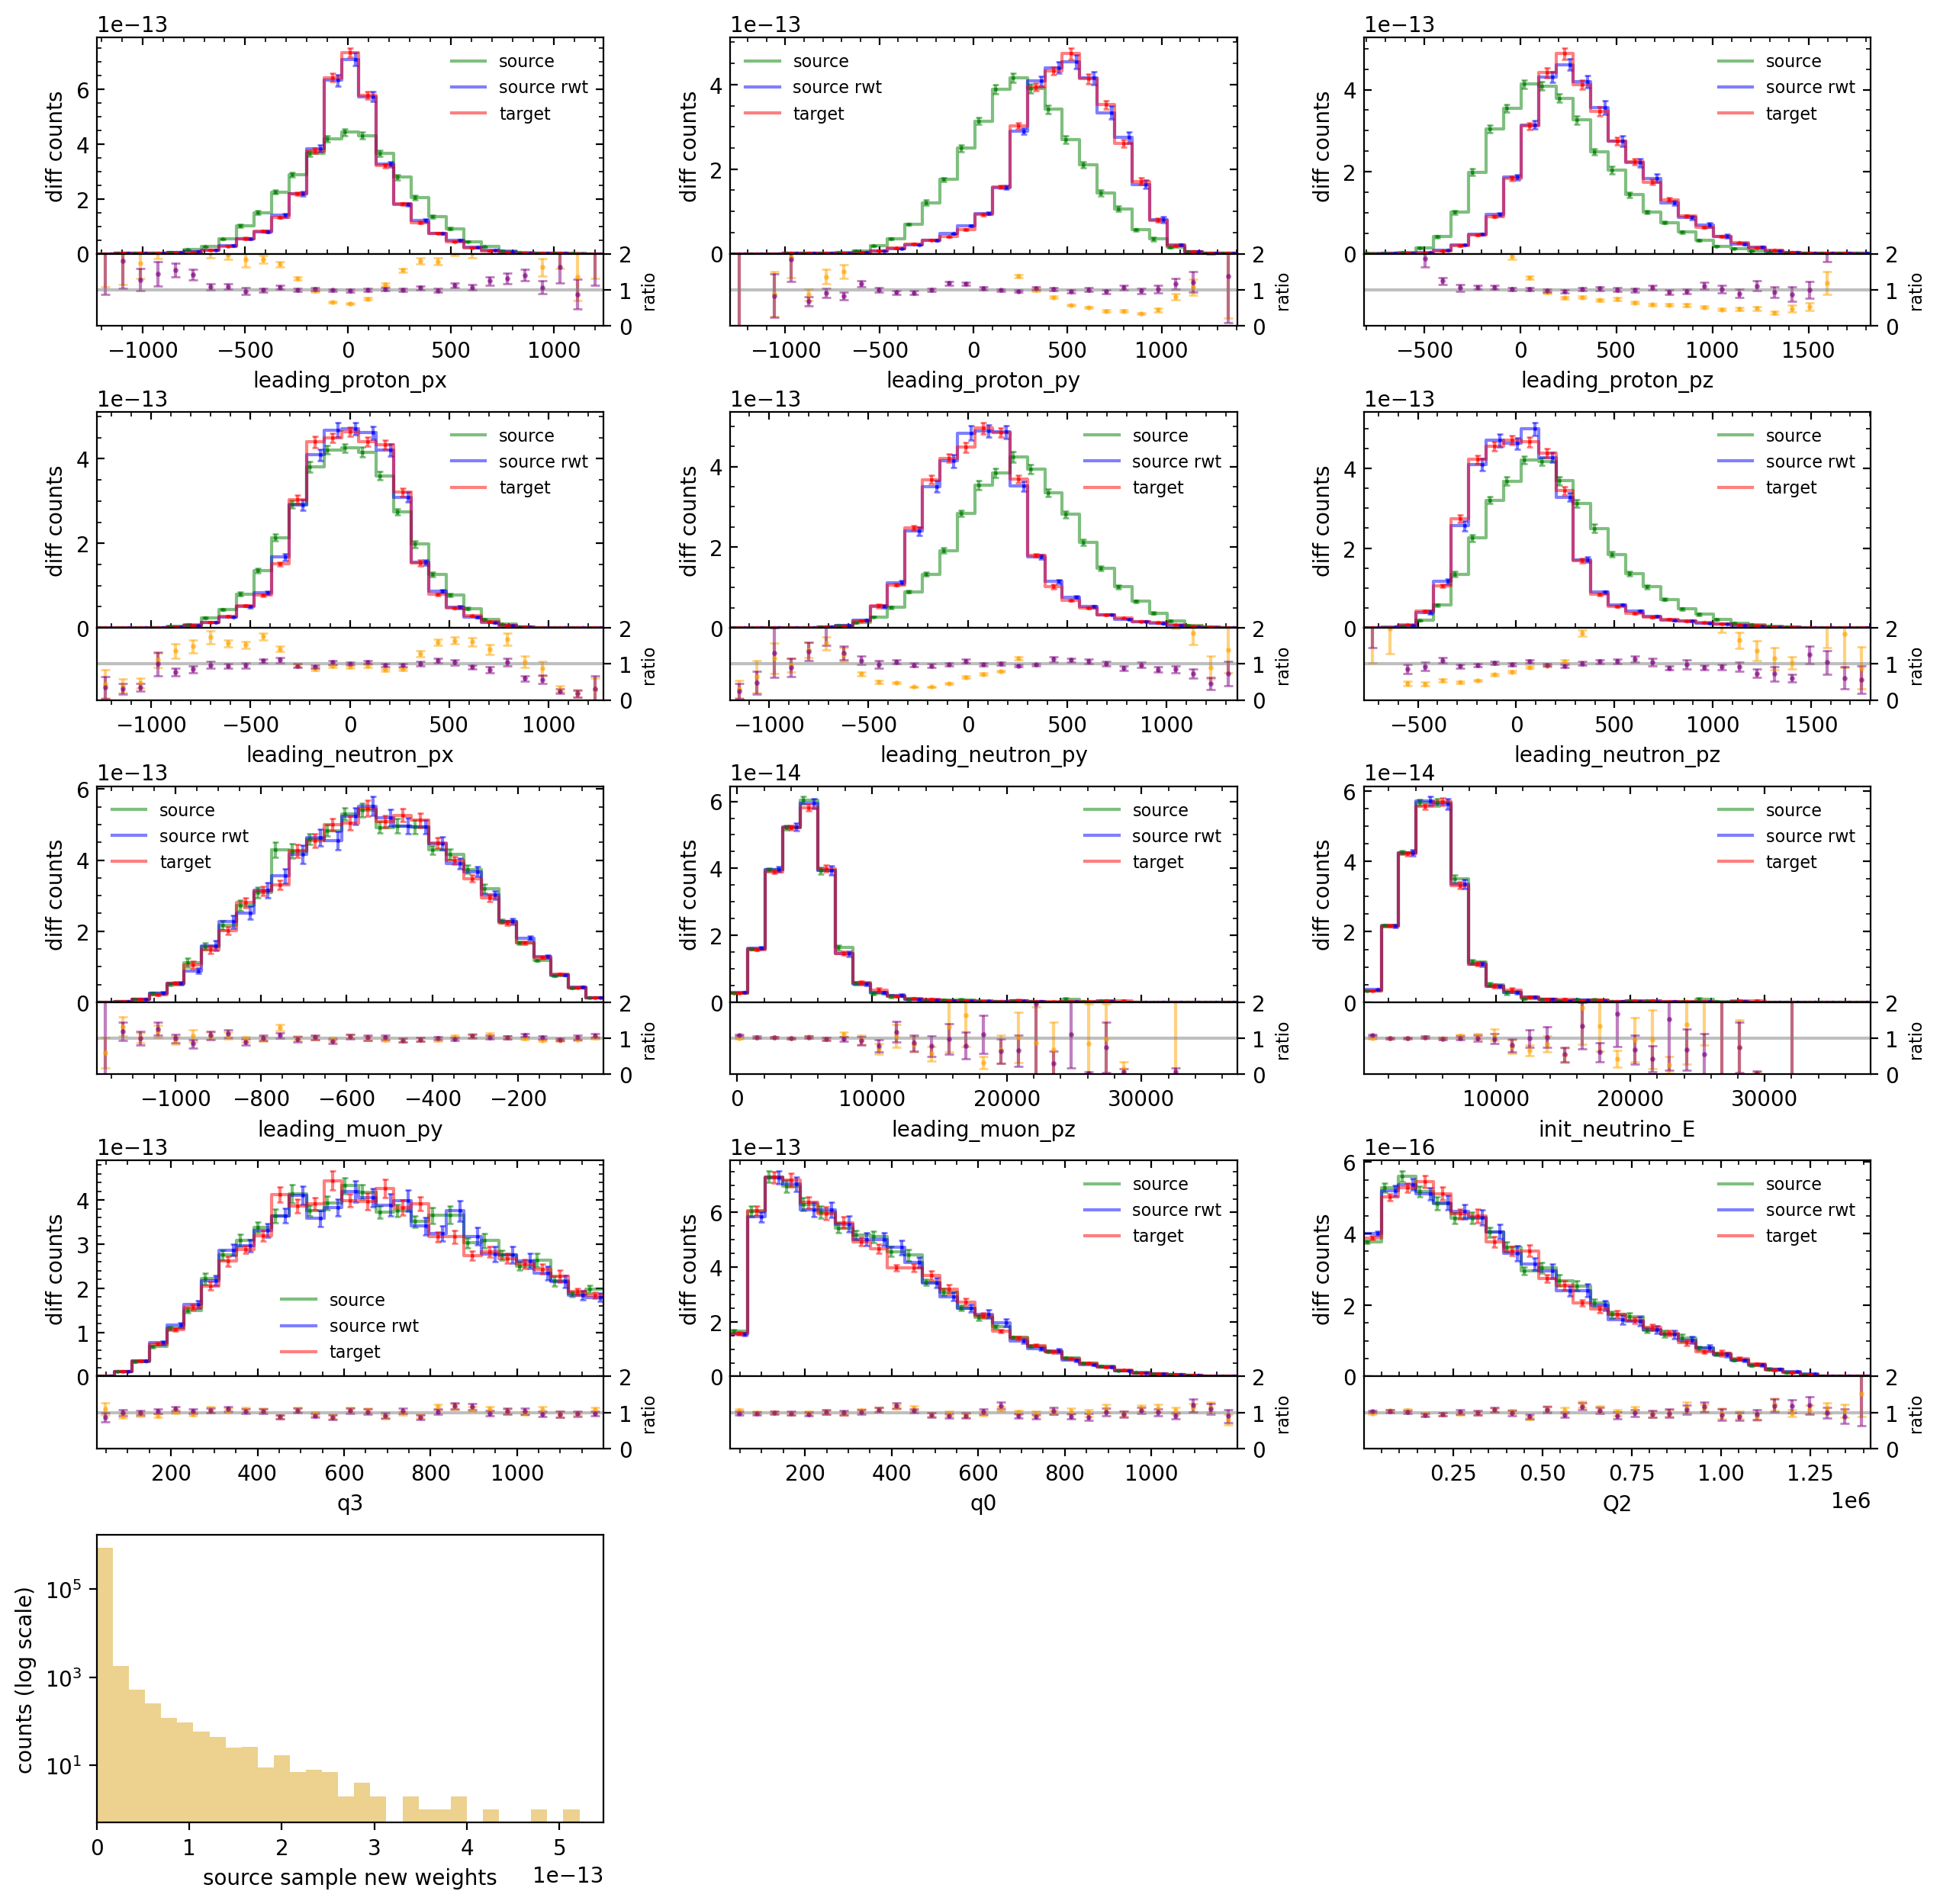

In [36]:
# predict weights
source_train['weight'] = reweighter.predict_matched_total_weights(source_train[reweight_variables], 
            original_weight=source_train[weight_channel],
            target_weight=target_train[weight_channel]
)
# source_test['weight'] = reweighter.predict_matched_total_weights(source_test[reweight_variables], 
#             original_weight=source_test[weight_channel],
#             target_weight=target_test[weight_channel]
# )
drawing_variables=[
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz',
    'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz',
    'leading_muon_py', 'leading_muon_pz',
    'init_neutrino_E',
    'q3', 'q0','Q2',
    'weight',
]

mask = source_train['weight']>=0
draw_source_target_distributions_and_ratio(source_train.loc[mask], target_train, variables=drawing_variables,
    source_weights=source_train.loc[mask][weight_channel], 
    new_source_weights=source_train.loc[mask]['weight'], 
    target_weights=target_train[weight_channel]
)


### 2p2h np chanel:

In [ ]:
# Choose training set size
# total entries: 10,000,000
# size = 200000 # training time ~ 8 min
size = 1000000 # training time ~ 40 min

weight_channel = 'weight_np'

variables = {'muon_E':'leading_muon_E', 'muon_Px':'leading_muon_px', 'muon_Py':'leading_muon_py', 'muon_Pz':'leading_muon_pz', 'muon_P':'leading_muon_P', 
    'neutrino_E':'init_neutrino_E', 'neutrino_Px':'init_neutrino_px', 'neutrino_Py':'init_neutrino_py',
    'neutrino_Pz':'init_neutrino_pz', 'neutrino_P':'init_neutrino_P',
    'nucleon2_out_E':'leading_proton_E', 'nucleon2_out_Px':'leading_proton_px', 'nucleon2_out_Py':'leading_proton_py', 
    'nucleon2_out_Pz':'leading_proton_pz','nucleon2_out_P':'leading_proton_P',
    'nucleon1_out_E':'leading_neutron_E', 'nucleon1_out_Px':'leading_neutron_px', 'nucleon1_out_Py':'leading_neutron_py', 
    'nucleon1_out_Pz':'leading_neutron_pz','nucleon1_out_P':'leading_neutron_P', 
    'Q_E':'qtransfer_E', 'Q_Px':'qtransfer_px', 'Q_Py':'qtransfer_py', 'Q_Pz':'qtransfer_pz', 'Q_P':'qtransfer_P', weight_channel:weight_channel}

data_folder = '/exp/minerva/data/users/zihaolin/MC_outputs/Valencia/PreFsi'

source_train = uproot.open(f'{data_folder}/KinematicVariables_Enu=_Minerva__Inclusive.root')['T'].arrays(library='pd',entry_start=0, entry_stop=size)[variables.keys()]
target_train = uproot.open(f'{data_folder}/KinematicVariables_Enu=_Minerva__Exclusive.root')['T'].arrays(library='pd',entry_start=size, entry_stop=size*2)[variables.keys()]
# source_test = uproot.open(f'{data_folder}/KinematicVariables_Enu=_Minerva__Inclusive.root')['T'].arrays(library='pd',entry_start=size*2, entry_stop=size*3)[variables.keys()]
# target_test = uproot.open(f'{data_folder}/KinematicVariables_Enu=_Minerva__Exclusive.root')['T'].arrays(library='pd',entry_start=size*3, entry_stop=size*4)[variables.keys()]

source_train = source_train.loc[source_train[weight_channel]>=0]
target_train = target_train.loc[target_train[weight_channel]>=0]
# source_test = source_test.loc[source_test[weight_channel]>=0]
# target_test = target_test.loc[target_test[weight_channel]>=0]


source_train = source_train.rename(columns = variables)
target_train = target_train.rename(columns = variables)
# source_test = source_test.rename(columns = variables)
# target_test = target_test.rename(columns = variables)

source_train = transform_momentum_to_reaction_frame(source_train, selector_lepton='leading_muon', particle_names=['leading_neutron','leading_proton','qtransfer'])
target_train = transform_momentum_to_reaction_frame(target_train, selector_lepton='leading_muon', particle_names=['leading_neutron','leading_proton','qtransfer'])
# source_test = transform_momentum_to_reaction_frame(source_test, selector_lepton='leading_muon', particle_names=['leading_proton','subleading_proton','qtransfer'])
# target_test = transform_momentum_to_reaction_frame(target_test, selector_lepton='leading_muon', particle_names=['leading_proton','subleading_proton','qtransfer'])

# for df in [source_train, source_test, target_train, target_test]:
for df in [source_train, target_train]:
    df['q0'] = df['qtransfer_E']
    df['q3'] = df['qtransfer_P']
    df['Q2'] = df['q3']**2 - df['q0']**2

# train reweighter
reweight_variables = [
    'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz',
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz',
    'leading_muon_py', 'leading_muon_pz',
    # 'init_neutrino_E'
]

reweighter = Reweighter(n_estimators=200, learning_rate=0.1, max_depth=4, min_samples_leaf=20, gb_args={'subsample': 1.0})
reweighter.fit(source_train[reweight_variables], target_train[reweight_variables],
            original_weight=source_train[weight_channel],
            target_weight=target_train[weight_channel]
)

reweighter.save_to_pickle(f'/exp/minerva/data/users/zihaolin/BDTReweighters/saved_reweighters_pickle/Valencia/reweighter_MINERvA_flux_Valencia_2p2h_inclusive_to_exclusive_{weight_channel}.pkl')

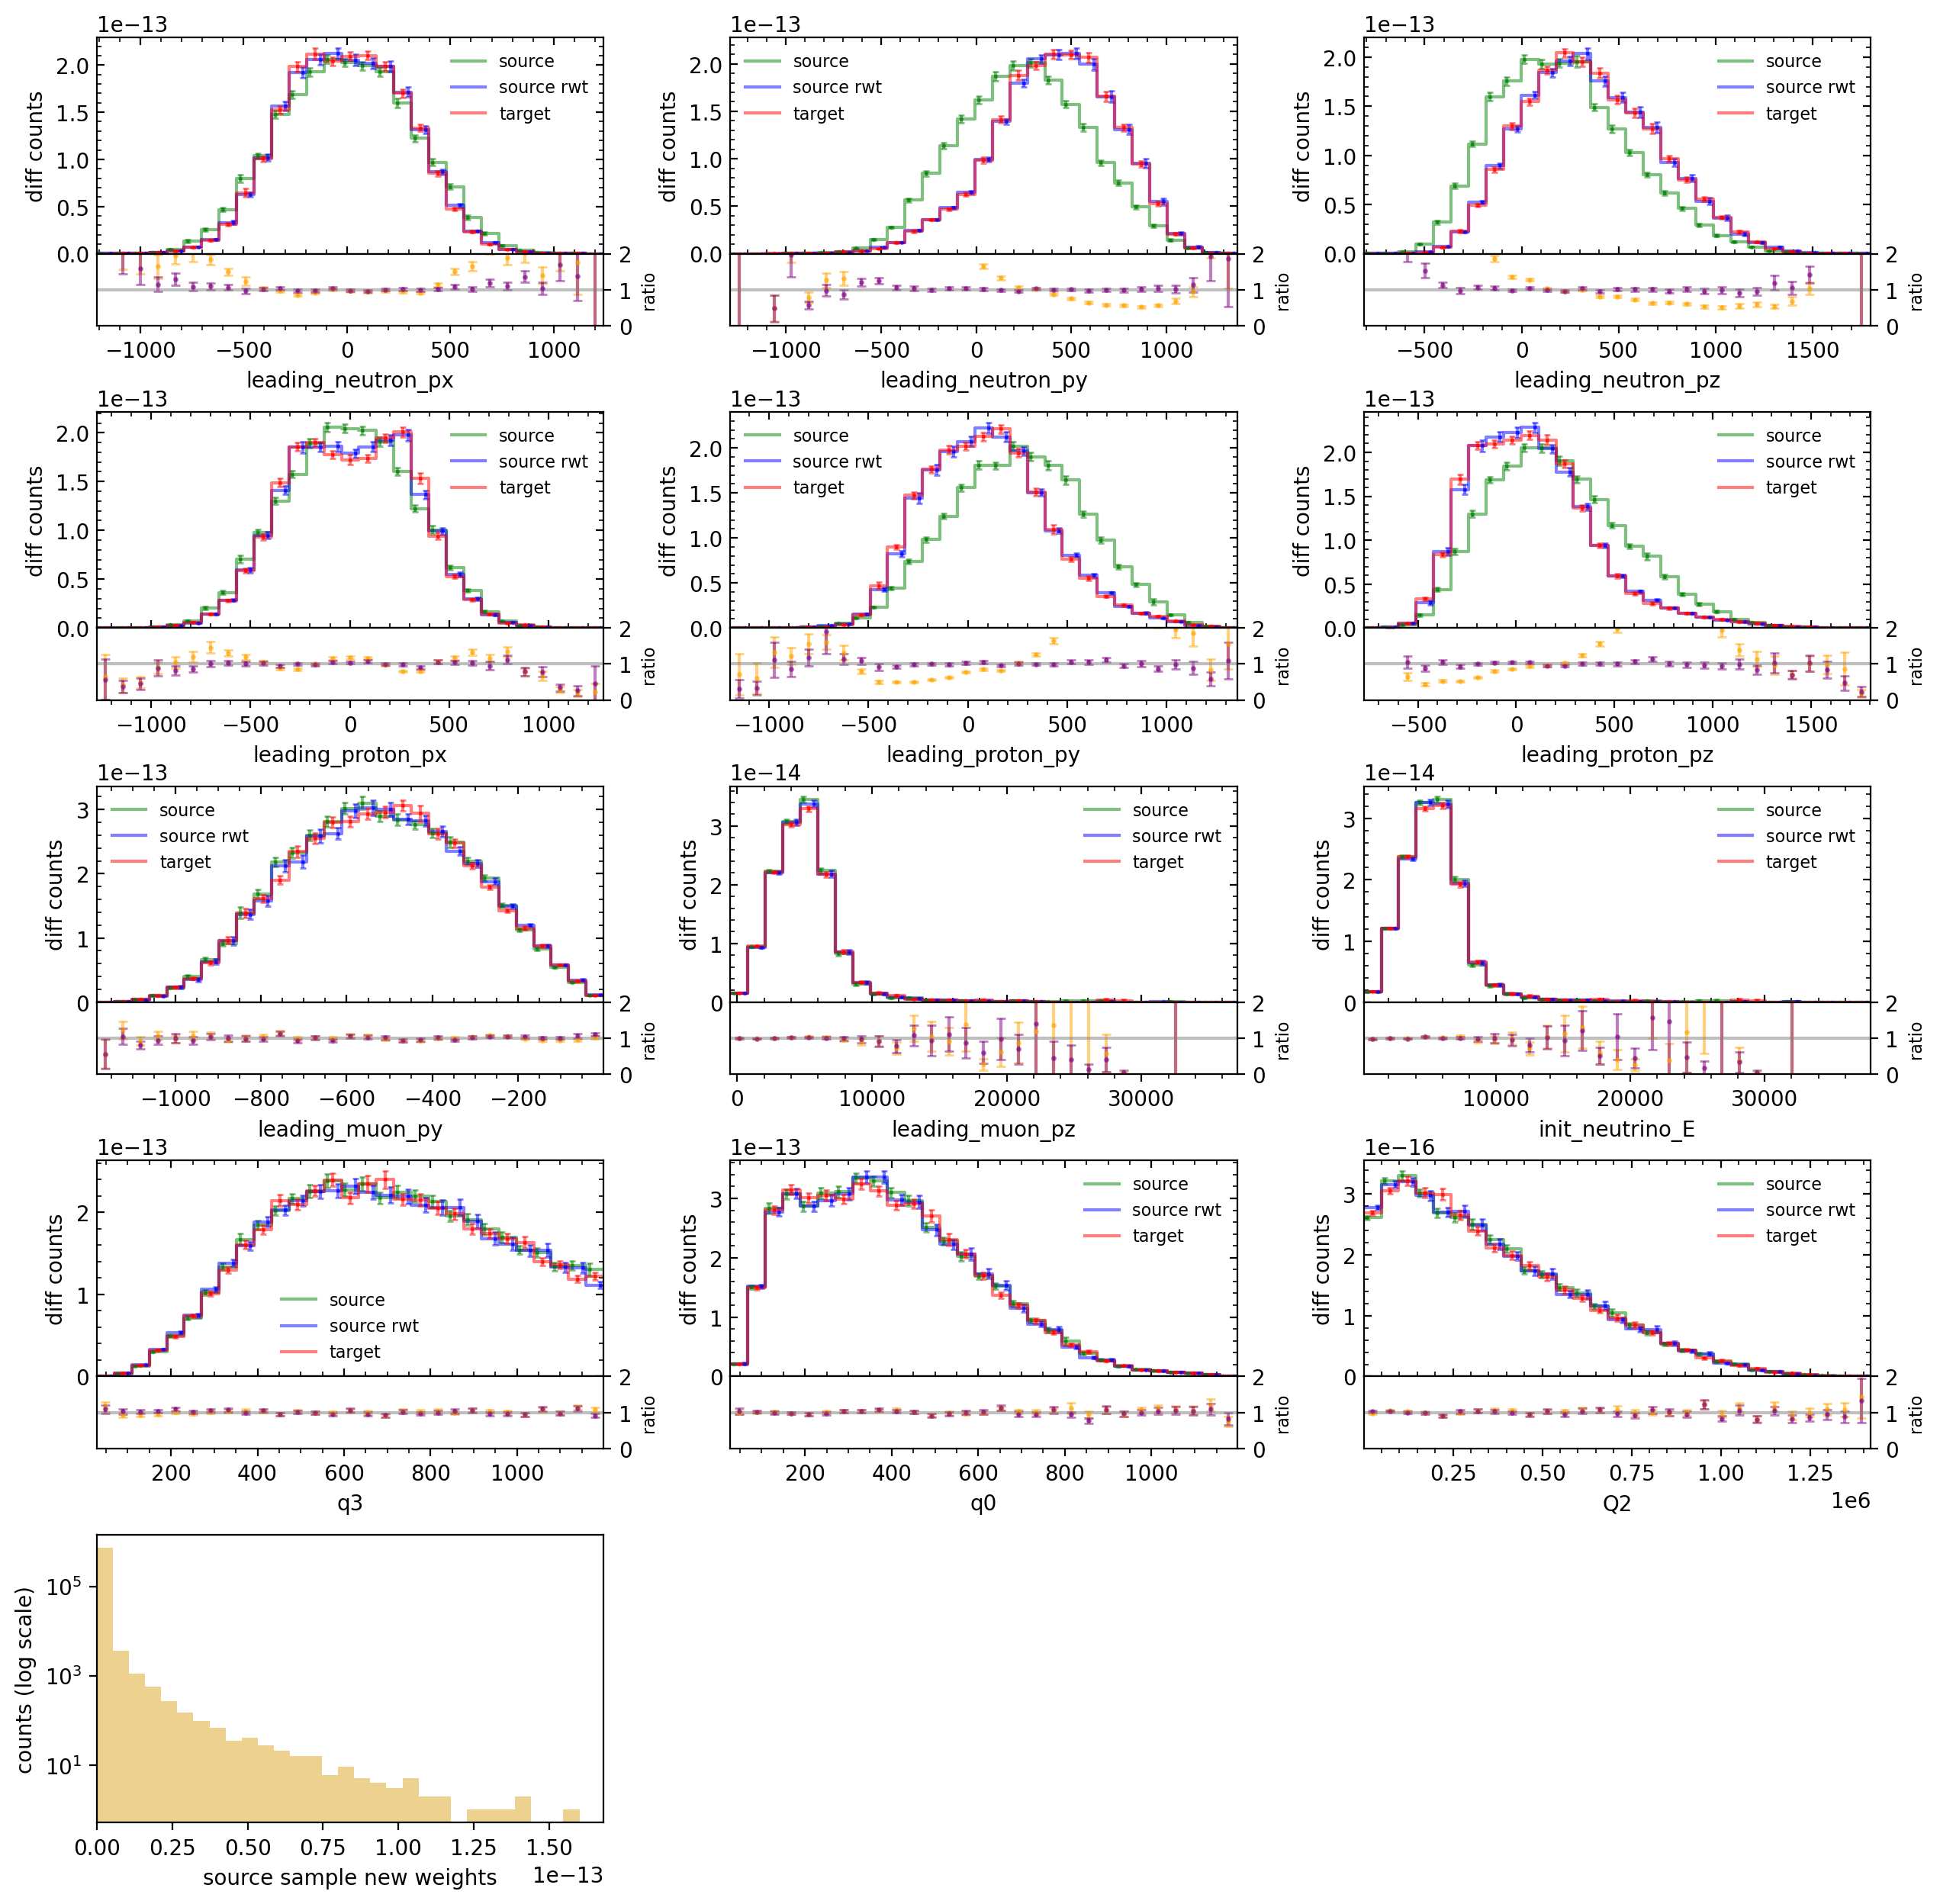

In [38]:
# predict weights
source_train['weight'] = reweighter.predict_matched_total_weights(source_train[reweight_variables], 
            original_weight=source_train[weight_channel],
            target_weight=target_train[weight_channel]
)
# source_test['weight'] = reweighter.predict_matched_total_weights(source_test[reweight_variables], 
#             original_weight=source_test[weight_channel],
#             target_weight=target_test[weight_channel]
# )
drawing_variables=[
    'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz',
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz',
    'leading_muon_py', 'leading_muon_pz',
    'init_neutrino_E',
    'q3', 'q0','Q2',
    'weight',
]

mask = source_train['weight']>=0
draw_source_target_distributions_and_ratio(source_train.loc[mask], target_train, variables=drawing_variables,
    source_weights=source_train.loc[mask][weight_channel], 
    new_source_weights=source_train.loc[mask]['weight'], 
    target_weights=target_train[weight_channel]
)
